In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_json('json/corpus.json')
df = df.reset_index().drop(columns = ['index'])

In [3]:
df.head(1)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,"[adult standards, brill building pop, bubblegu...",[1958-08-08],[1],1


In [7]:
all_weeks = []

for ind, item in df['weeks_list'].iteritems():
    for week in item:
        all_weeks.append(week)
        
weeks = pd.Series(all_weeks).value_counts().index

In [12]:
weeks = sorted(weeks)[1:]

In [189]:
empty = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

In [17]:
features = empty

keys = features.keys()

for week in weeks :
    week_features = empty
        
    for ind, row in df.iterrows():
        if week in row['weeks_list']: 
            for key in keys:
                week_features[key].append(row[key])
    
    for key in keys:
        features[key].append(week_features[key])

In [93]:
def mean_confidence_interval(data, confidence = 0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [94]:
def compute_bounds(features, feature):
    
    lower_bound, mean, upper_bound = [], [], []

    # Compute the 95% confidence interval
    for week in range(len(features[feature])):
        m, lb, ub = mean_confidence_interval(features[feature][week])
    
        lower_bound.append(lb)
        mean.append(m)
        upper_bound.append(ub)
        
    return lower_bound, mean, upper_bound

In [117]:
def plot_feature_evolution(features, feature, color = 'b'):
    
    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    
    years = np.arange(1959, 1997)
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*48, 48), years, rotation = 'vertical')
    plt.xlabel('Weeks')
    plt.ylabel(name)
    plt.title(name + ' change at week granularity \n')

    return plt

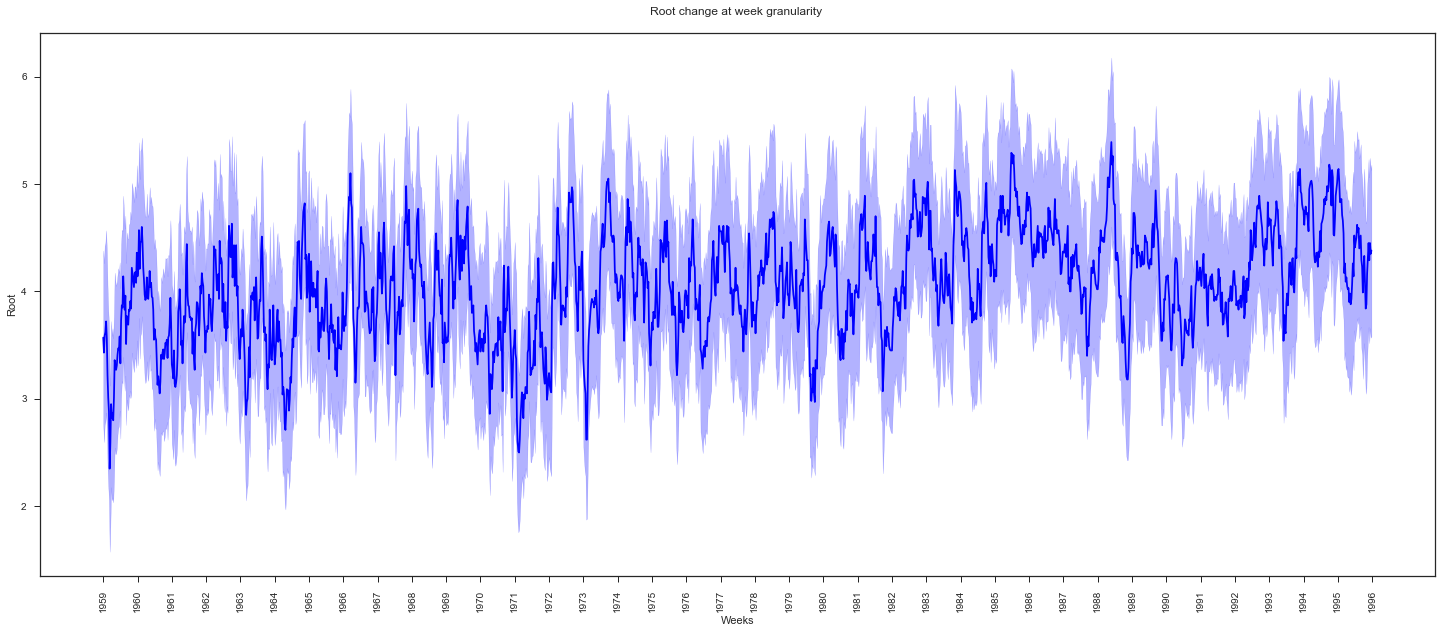

In [96]:
plot_feature_evolution(features, 'root');

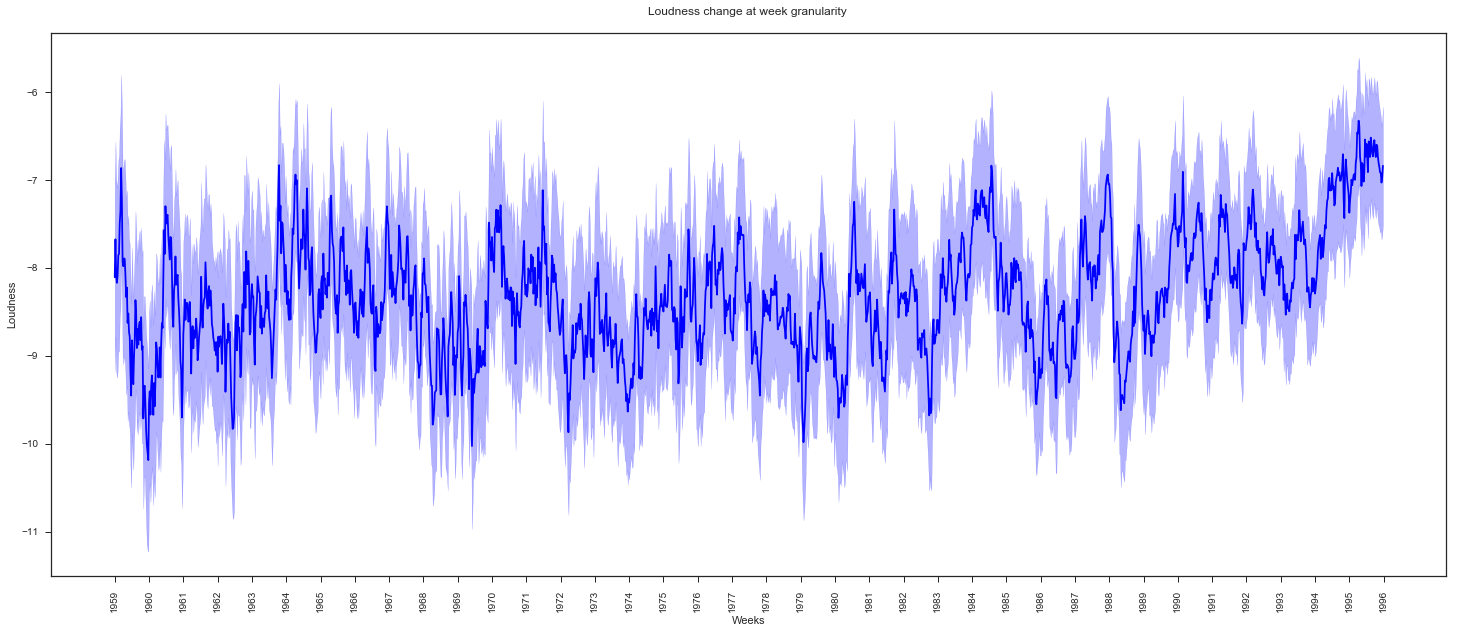

In [97]:
plot_feature_evolution(features, 'loudness');

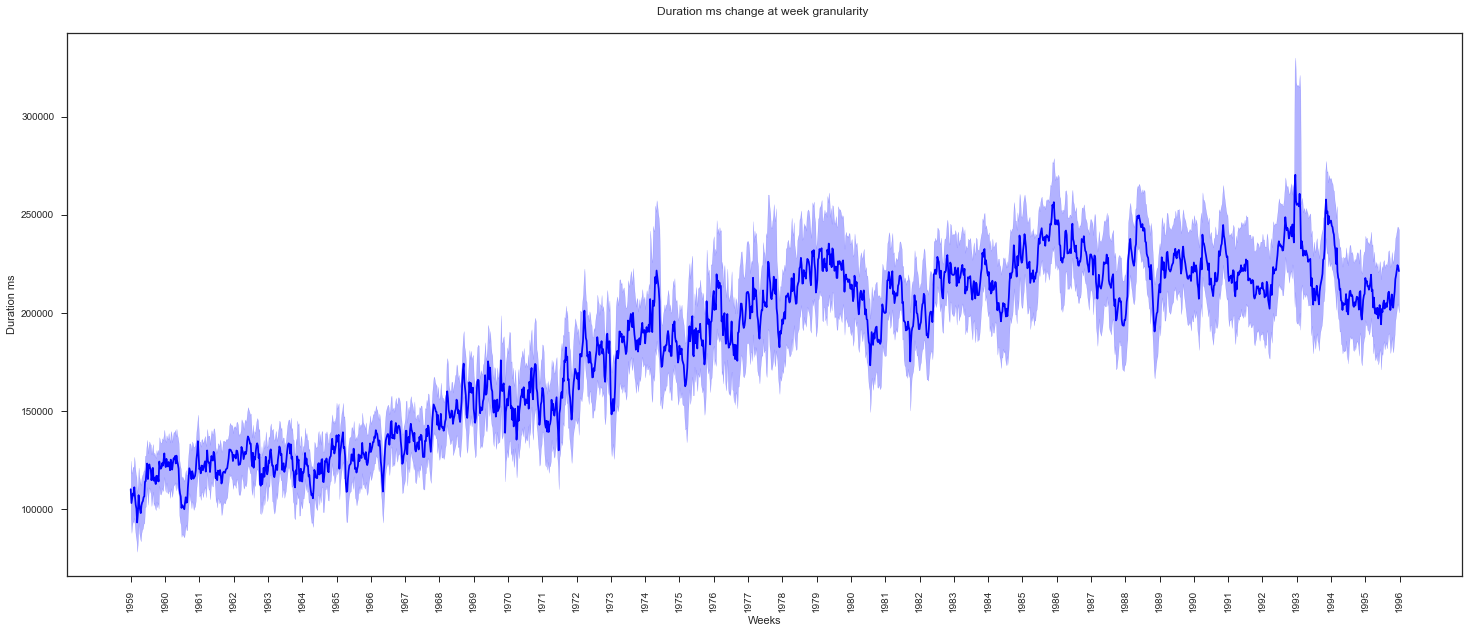

In [98]:
plot_feature_evolution(features, 'duration_ms');

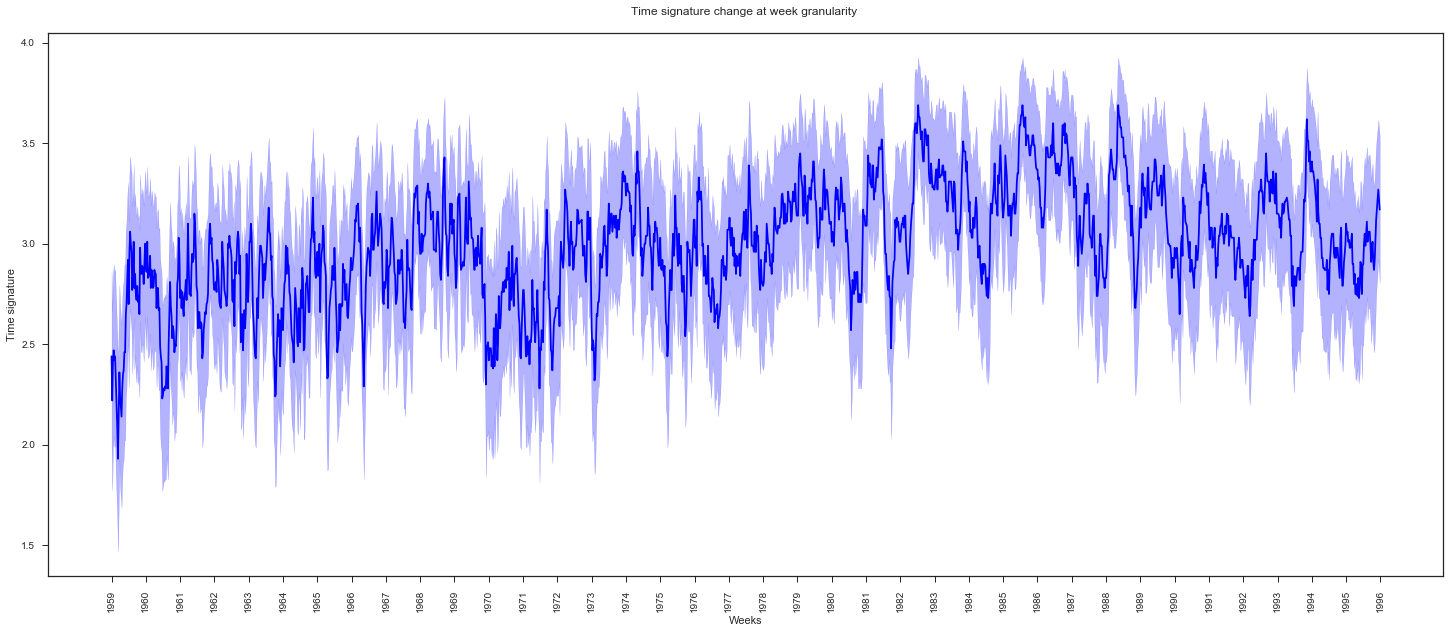

In [99]:
plot_feature_evolution(features, 'time_signature');

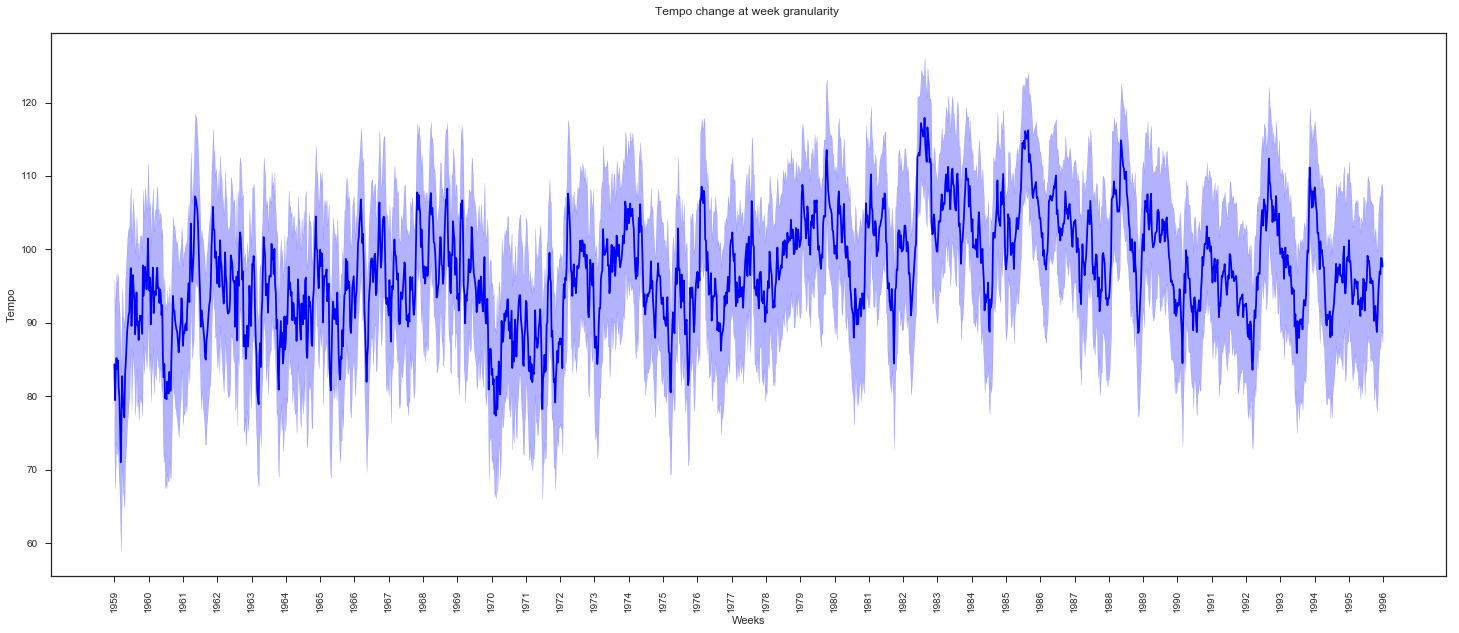

In [100]:
plot_feature_evolution(features, 'tempo');

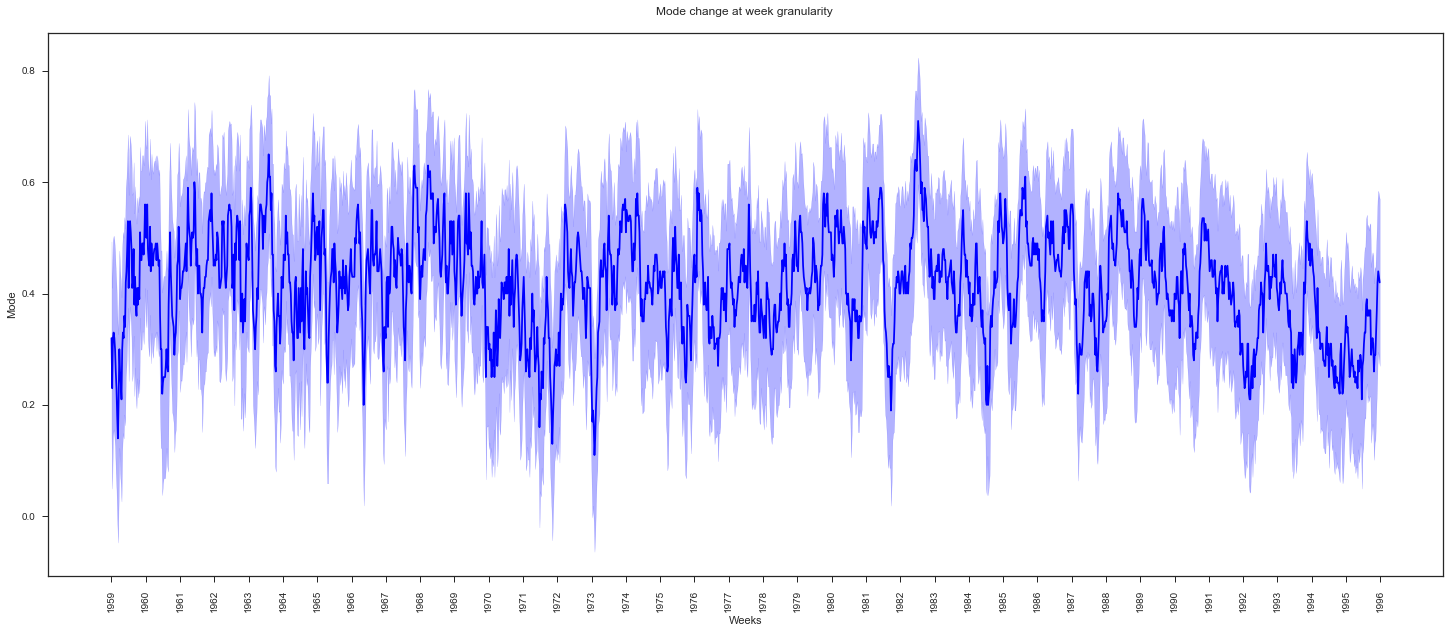

In [101]:
plot_feature_evolution(features, 'mode');

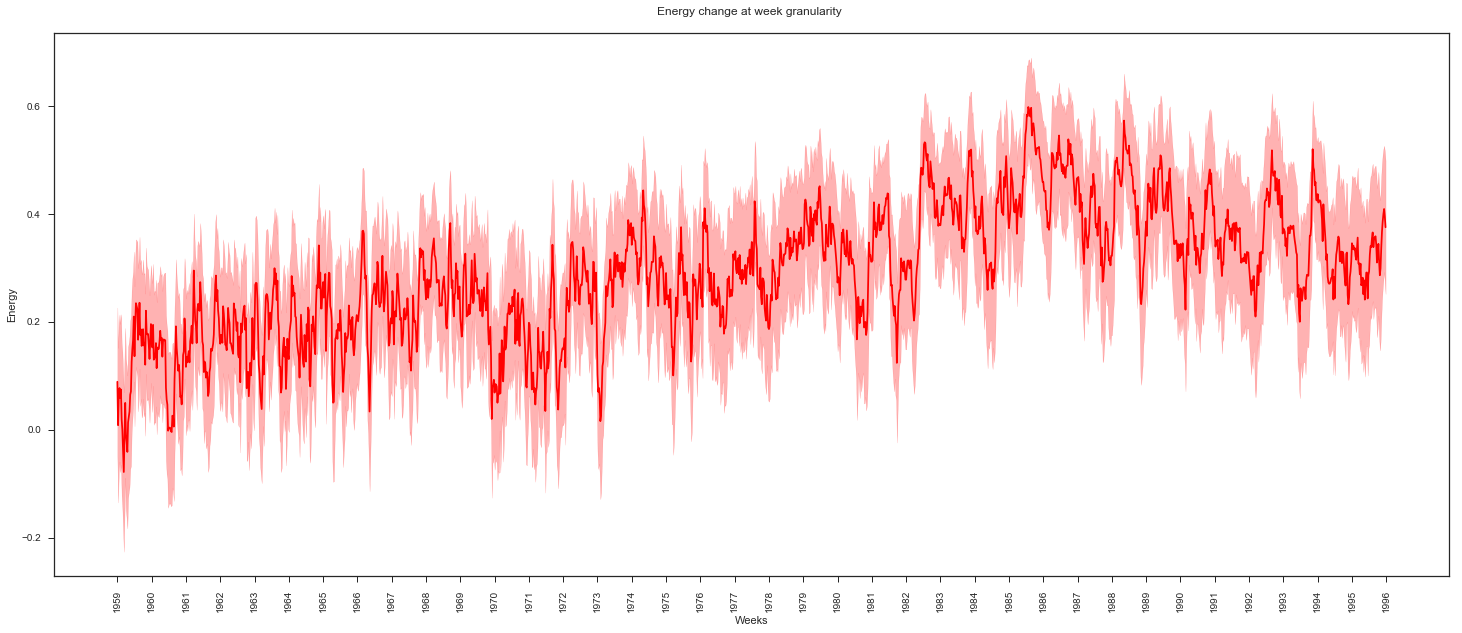

In [102]:
plot_feature_evolution(features, 'energy', color = 'r');

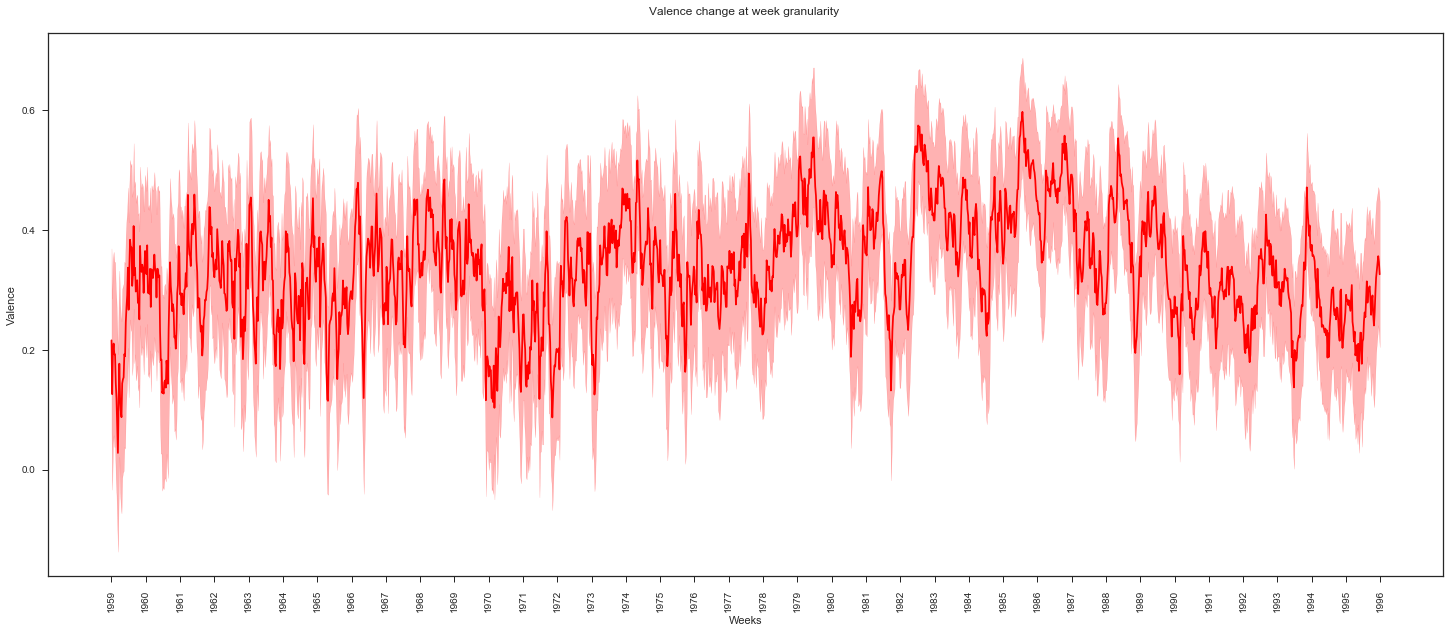

In [103]:
plot_feature_evolution(features, 'valence', color = 'r');

In [104]:
trend = empty

for key in trend.keys():
    for i in range(len(weeks)):
        trend[key].append(np.mean(features[key][i]))

In [105]:
df_trend = pd.DataFrame(trend)

In [110]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("ticks")

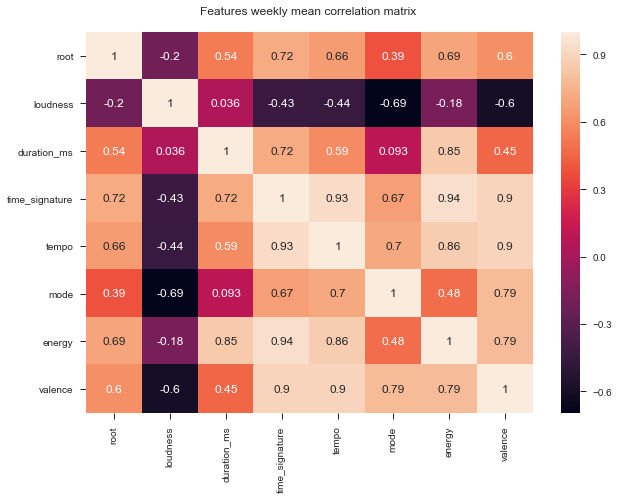

In [111]:
sns.heatmap(df_trend.corr(), annot=True).set_title('Features weekly mean correlation matrix \n');

In [358]:
means = empty

for key in trend.keys():
    means[key] = np.mean(trend[key])

In [359]:
means

{'root': 4.053211336336336,
 'loudness': -8.316193208094457,
 'duration_ms': 184317.67384134137,
 'time_signature': 2.992800186550186,
 'tempo': 96.87066419743607,
 'mode': 0.41672928610428617,
 'energy': 0.2909306072720448,
 'valence': 0.33595664212507964}

In [360]:
def salient_drift(features, feature, means):
    
    color = '#989898'
    lower_bound, mean, upper_bound = compute_bounds(features, feature)
    salient_low, salient_high = [], []
    ampl_low, ampl_high = [], []
    
    for i in range(len(lower_bound)):
        if lower_bound[i] > means[feature]:
            salient_high.append(i)
            ampl_high.append(mean[i])
            
        if upper_bound[i] < means[feature]:
            salient_low.append(i)
            ampl_low.append(mean[i])

    sns.set(rc={'figure.figsize':(30,10)})
    sns.set_style("ticks")
    
    years = np.arange(1959, 1997)
    #plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
    plt.plot(mean, color)
    plt.plot(salient_low, ampl_low, color='#01B9FF', marker='o', linestyle = '')
    plt.plot(salient_high, ampl_high, color='#FF0101', marker='o', linestyle = '')
    
    name = feature.replace('_', ' ').capitalize()
    plt.xticks(np.arange(0, (len(years))*48, 48), years, rotation = 'vertical')
    plt.xlabel('Weeks')
    plt.ylabel(name)
    plt.title(name + ' salient drifts at week granularity \n')

    return plt, salient_low, salient_high

In [361]:
salient_low_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}
salient_high_list = {'root': [], 'loudness': [], 'duration_ms': [], 'time_signature': [], 'tempo': [],
         'mode': [], 'energy': [], 'valence': []}

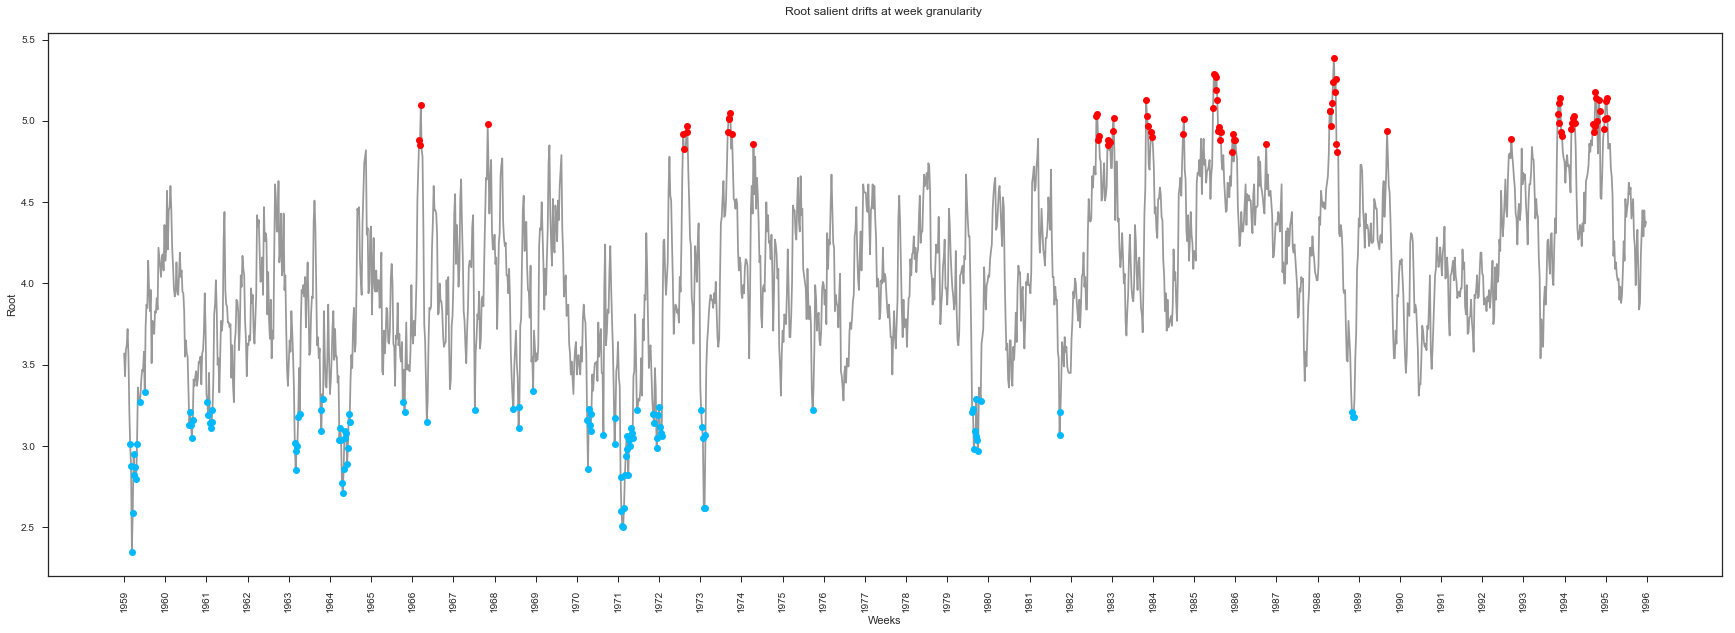

In [362]:
feature = 'root'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

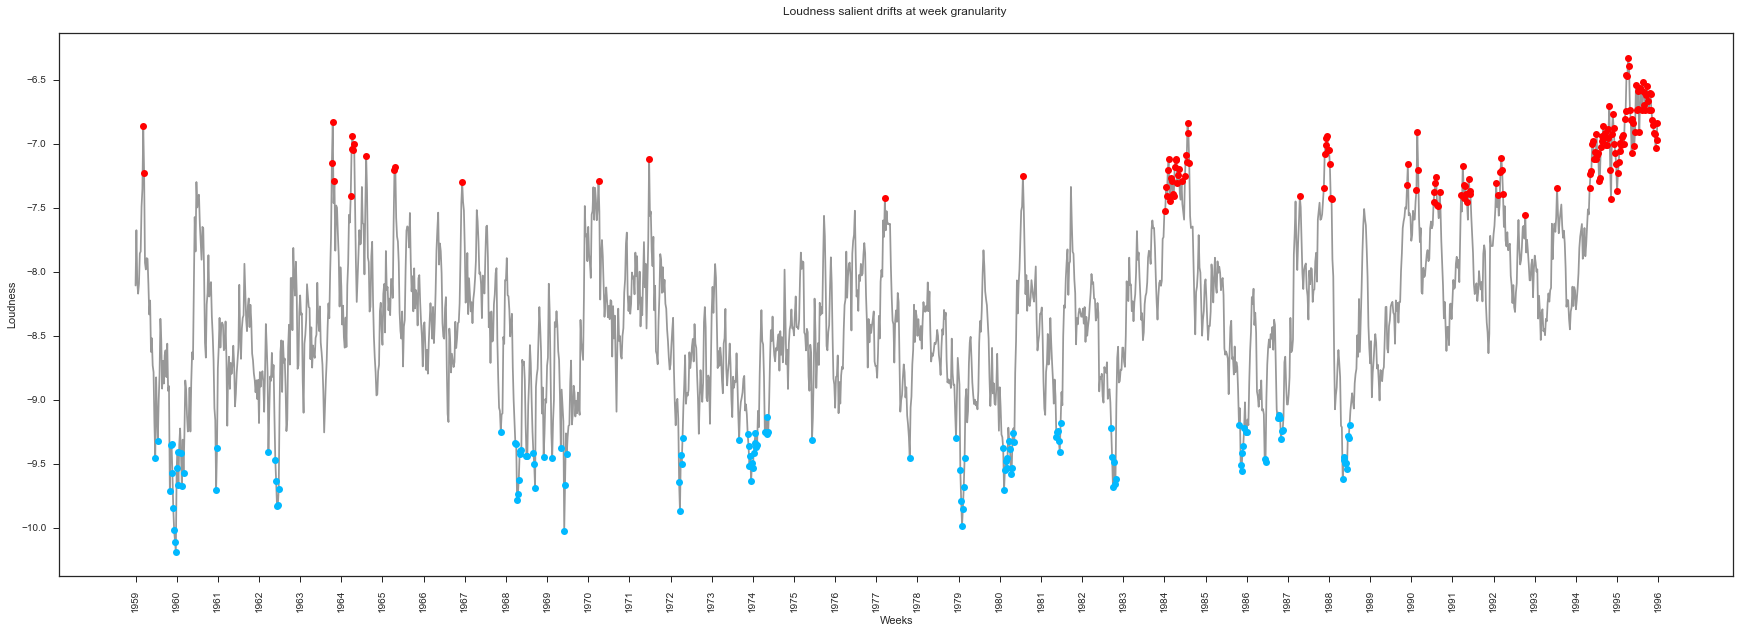

In [363]:
feature = 'loudness'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

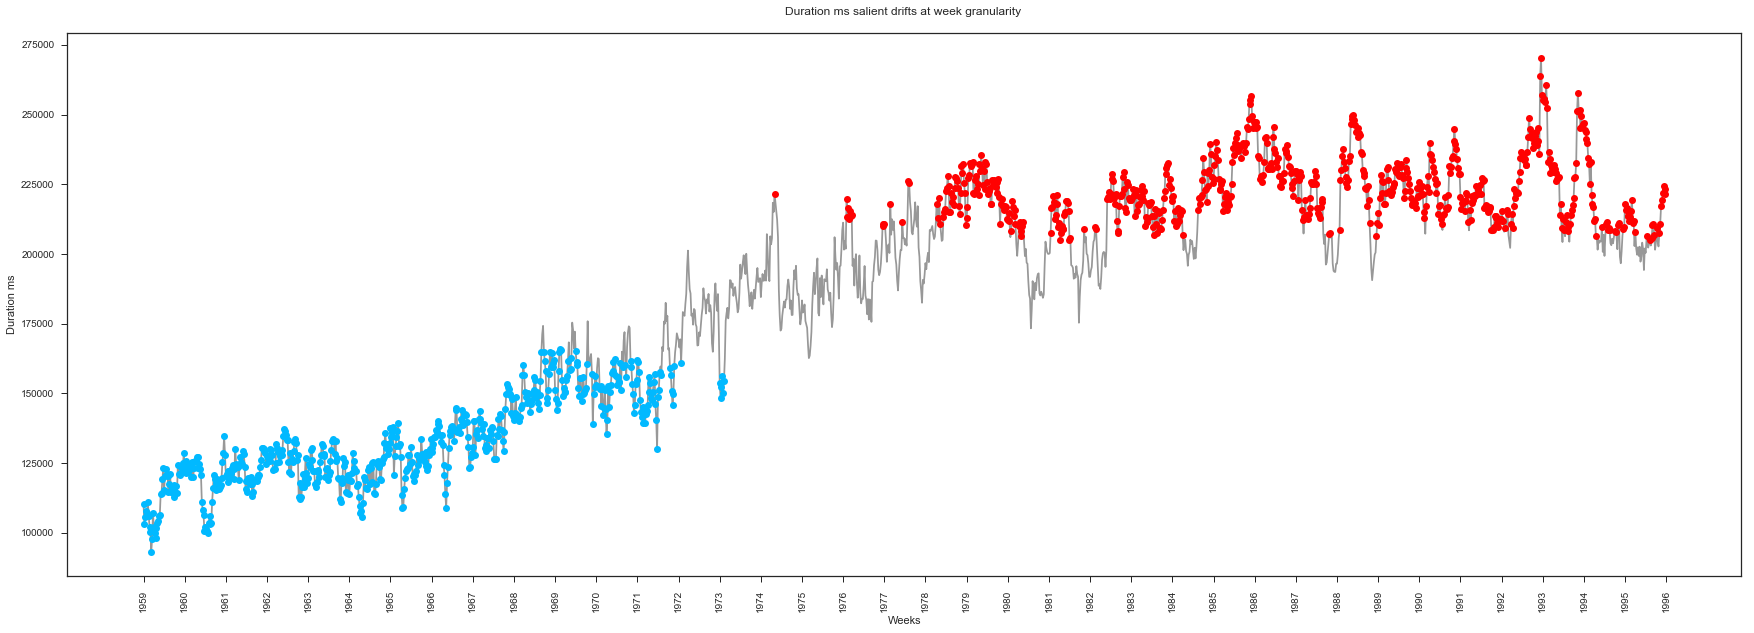

In [364]:
feature = 'duration_ms'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

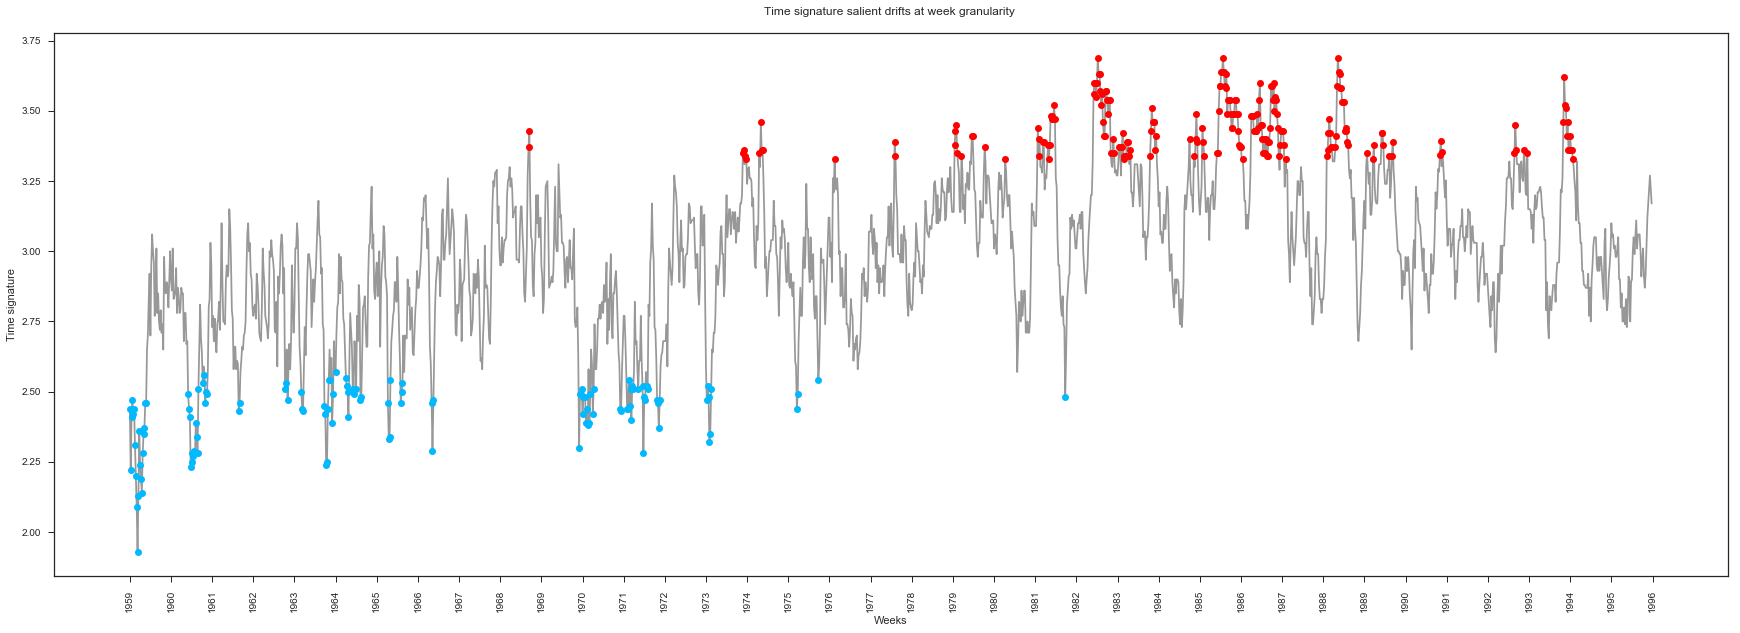

In [365]:
feature = 'time_signature'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

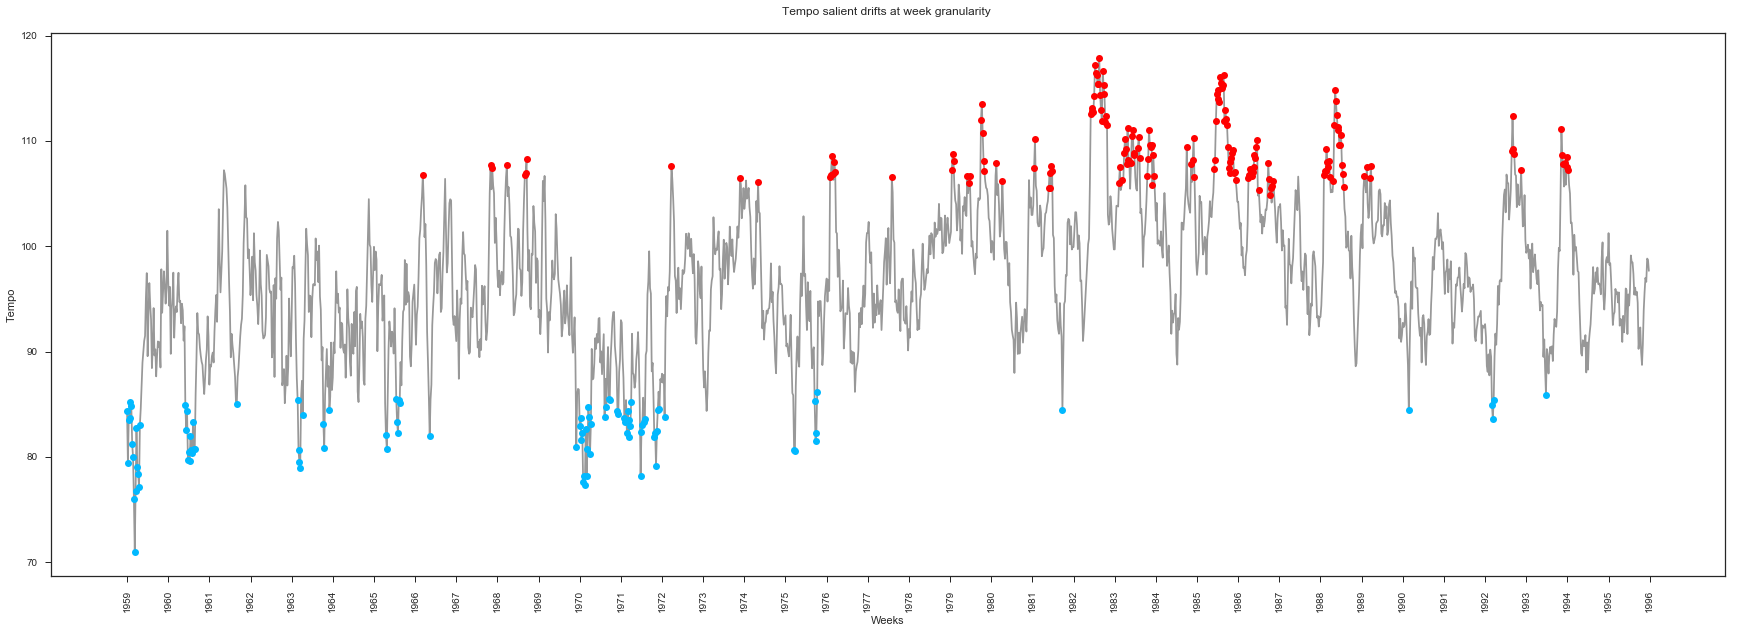

In [366]:
feature = 'tempo'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

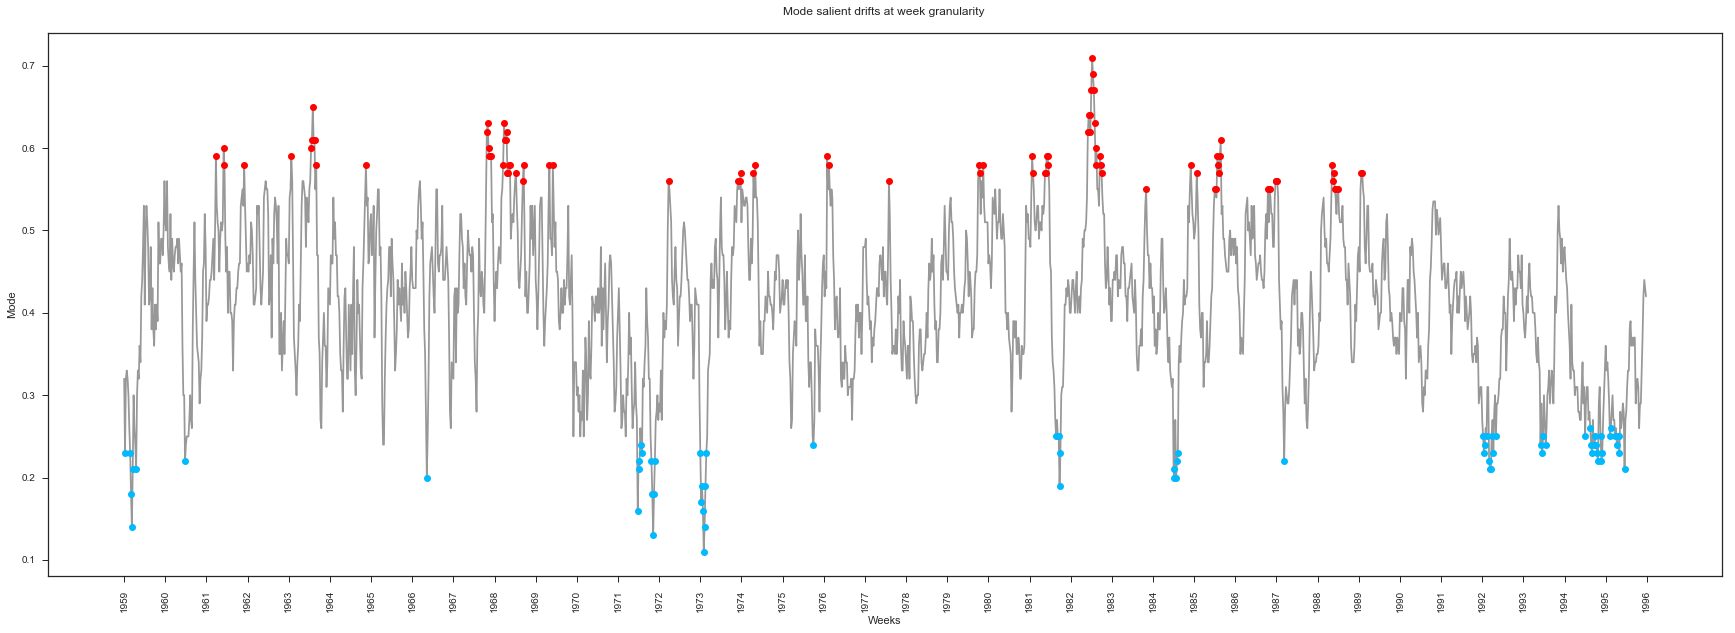

In [367]:
feature = 'mode'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

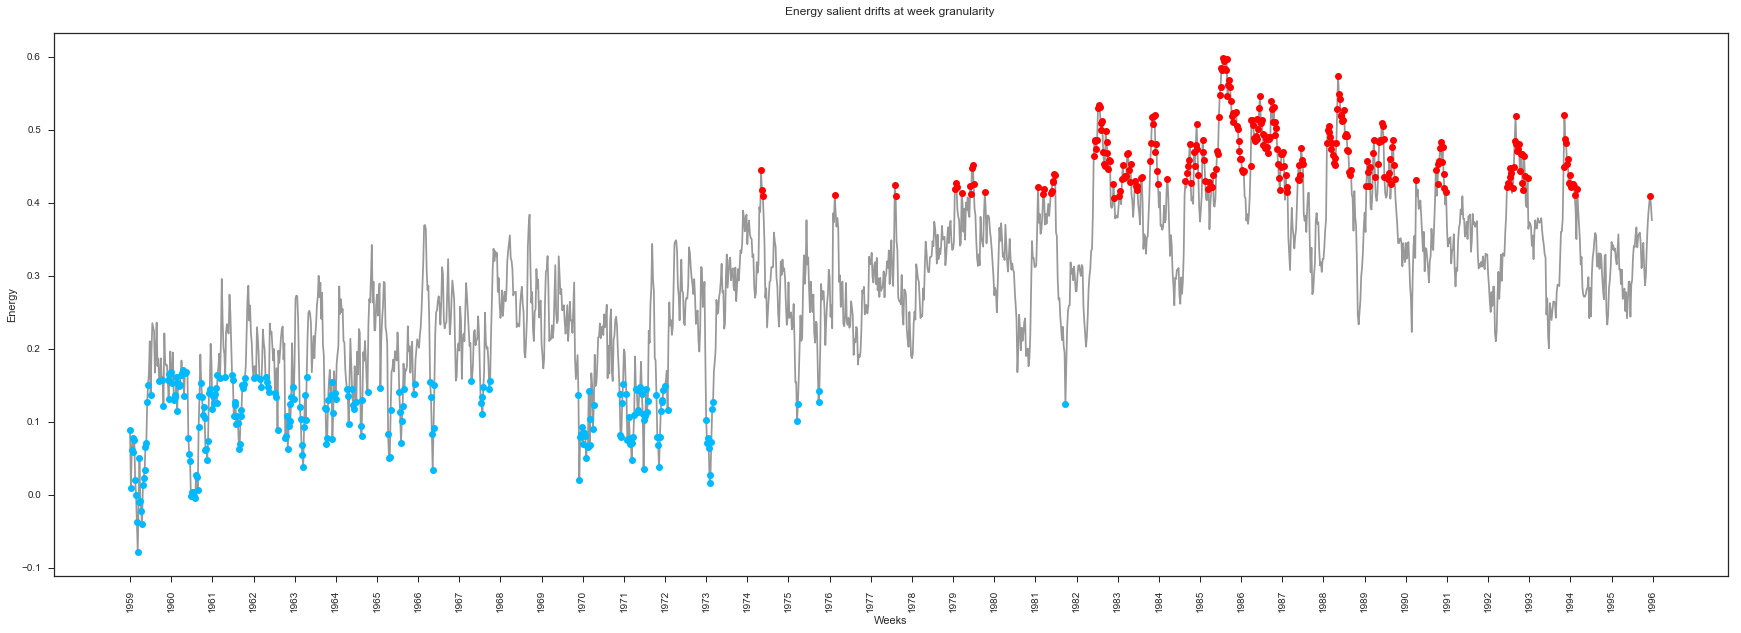

In [368]:
feature = 'energy'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

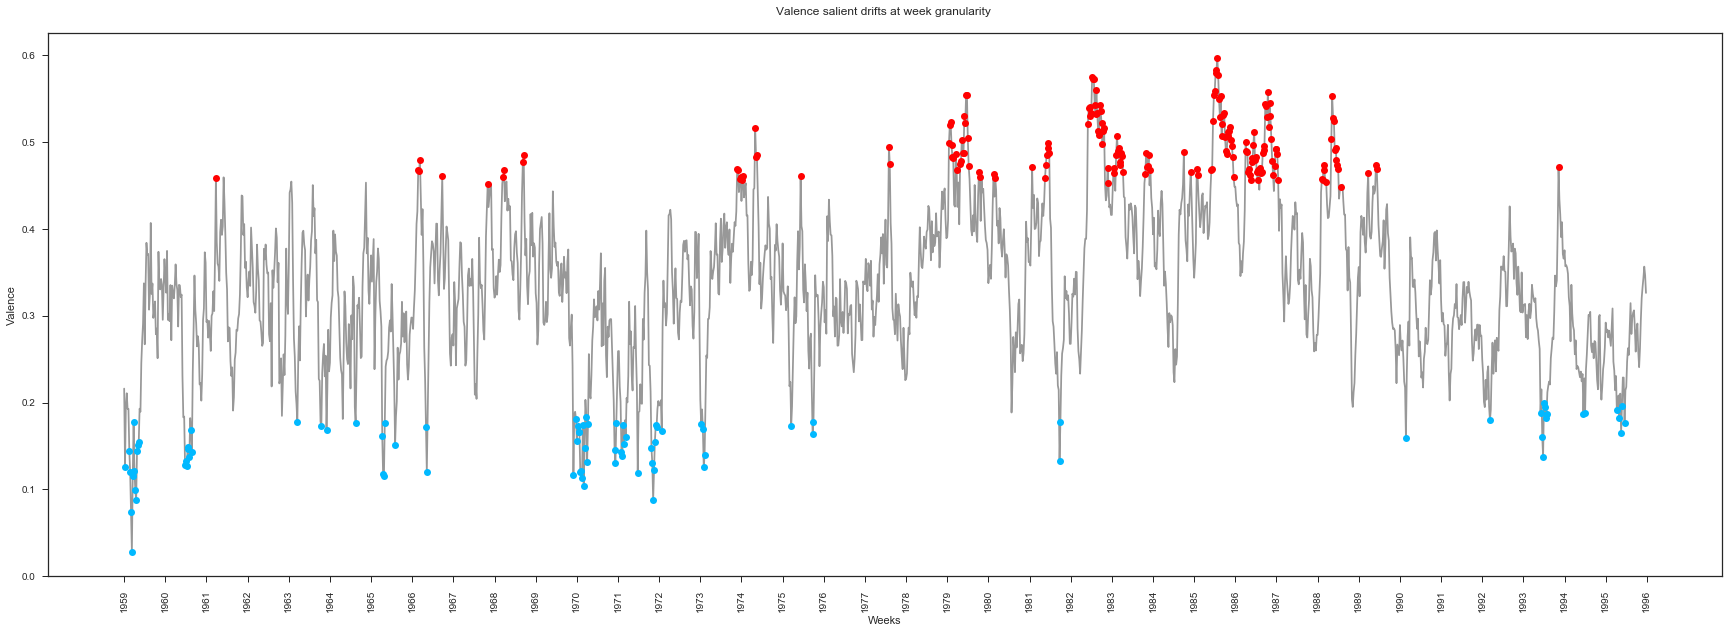

In [369]:
feature = 'valence'
plt, salient_low_list[feature], salient_high_list[feature] = salient_drift(features, feature, means)
plt.show;

In [370]:
explanative_features = ['root', 'loudness', 'time_signature', 'tempo', 'mode', 'valence']
keep_low, keep_high = [], []

for key in salient_low_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_low_list[key]:
            keep_low.append(element)

for key in salient_high_list.keys():
    if (key != 'duration_ms') & (key != 'energy'):
        for element in salient_high_list[key]:
            keep_high.append(element)

In [371]:
keep_low = pd.Series(keep_low).value_counts()
keep_high = pd.Series(keep_high).value_counts()

In [312]:
weeks = pd.Series(weeks)

In [372]:
salient_low = keep_low[keep_low.values >= 4].index
weeks[salient_low].sort_values()

1       1959-01-08
7       1959-02-22
8       1959-03-01
9       1959-03-08
10      1959-03-15
11      1959-03-22
12      1959-04-01
13      1959-04-08
14      1959-04-15
15      1959-04-22
71      1960-06-22
76      1960-08-01
78      1960-08-15
79      1960-08-22
202     1963-03-15
230     1963-10-15
353     1966-05-08
540     1970-04-01
541     1970-04-08
572     1970-12-01
573     1970-12-08
580     1971-02-01
581     1971-02-08
583     1971-02-22
585     1971-03-08
599     1971-06-22
615     1971-10-22
616     1971-11-01
617     1971-11-08
618     1971-11-15
673     1973-01-08
675     1973-01-22
676     1973-02-01
677     1973-02-08
803     1975-09-22
1091    1981-09-22
dtype: object

In [373]:
salient_high = keep_high[keep_high.values >= 4].index
weeks[salient_high].sort_values()

424     1967-11-01
465     1968-09-08
466     1968-09-15
736     1974-05-01
892     1977-08-01
997     1979-10-08
1059    1981-01-22
1075    1981-05-22
1076    1981-06-01
1077    1981-06-08
1078    1981-06-15
1124    1982-06-01
1125    1982-06-08
1126    1982-06-15
1127    1982-06-22
1128    1982-07-01
1129    1982-07-08
1130    1982-07-15
1131    1982-07-22
1132    1982-08-01
1133    1982-08-08
1134    1982-08-15
1135    1982-08-22
1136    1982-09-01
1137    1982-09-08
1138    1982-09-15
1139    1982-09-22
1140    1982-10-01
1192    1983-11-01
1193    1983-11-08
1194    1983-11-15
1236    1984-10-01
1244    1984-12-01
1270    1985-06-15
1271    1985-06-22
1272    1985-07-01
1273    1985-07-08
1274    1985-07-15
1275    1985-07-22
1276    1985-08-01
1277    1985-08-08
1278    1985-08-15
1279    1985-08-22
1292    1985-12-01
1293    1985-12-08
1332    1986-10-01
1334    1986-10-15
1336    1986-11-01
1408    1988-05-01
1409    1988-05-08
1410    1988-05-15
1411    1988-05-22
1412    1988